<a href="https://colab.research.google.com/github/DimpleB0501/eva8/blob/main/Session_6_Assignment_QnA/Session_6_Assignment_QnA.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
%matplotlib inline


Training a Classifier
=====================

This is it. You have seen how to define neural networks, compute loss and make
updates to the weights of the network.

Now you might be thinking,

What about data?
----------------

Generally, when you have to deal with image, text, audio or video data,
you can use standard python packages that load data into a numpy array.
Then you can convert this array into a ``torch.*Tensor``.

-  For images, packages such as Pillow, OpenCV are useful
-  For audio, packages such as scipy and librosa
-  For text, either raw Python or Cython based loading, or NLTK and
   SpaCy are useful

Specifically for vision, we have created a package called
``torchvision``, that has data loaders for common datasets such as
Imagenet, CIFAR10, MNIST, etc. and data transformers for images, viz.,
``torchvision.datasets`` and ``torch.utils.data.DataLoader``.

This provides a huge convenience and avoids writing boilerplate code.

For this tutorial, we will use the CIFAR10 dataset.
It has the classes: ‘airplane’, ‘automobile’, ‘bird’, ‘cat’, ‘deer’,
‘dog’, ‘frog’, ‘horse’, ‘ship’, ‘truck’. The images in CIFAR-10 are of
size 3x32x32, i.e. 3-channel color images of 32x32 pixels in size.

.. figure:: /_static/img/cifar10.png
   :alt: cifar10

   cifar10


Training an image classifier
----------------------------

We will do the following steps in order:

1. Load and normalizing the CIFAR10 training and test datasets using
   ``torchvision``
2. Define a Convolution Neural Network
3. Define a loss function
4. Train the network on the training data
5. Test the network on the test data

1. Loading and normalizing CIFAR10


Using ``torchvision``, it’s extremely easy to load CIFAR10.



In [2]:
import torch
import torchvision
import torchvision.transforms as transforms

# GPU Check

In [3]:
SEED = 1

# CUDA?
cuda = torch.cuda.is_available()
print("CUDA Available?", cuda)

# For reproducibility
torch.manual_seed(SEED)

if cuda:
    torch.cuda.manual_seed(SEED)

CUDA Available? True


The output of torchvision datasets are PILImage images of range [0, 1].
We transform them to Tensors of normalized range [-1, 1].



# Ablumentations library


In [4]:
# Import dependencies
!!pip install --upgrade albumentations
!pip install torchscan

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [5]:
import albumentations as A
from albumentations.pytorch import ToTensorV2
import copy
import random
import matplotlib.pyplot as plt

# Albumentations 

### Mean and standard deviation of the train dataset

In [6]:
def data_param ():
  cifar_trainset = torchvision.datasets.CIFAR10(root='./data', train=True, download=True)
  data = cifar_trainset.data / 255 # data is numpy array
  mean = data.mean(axis = (0,1,2)) 
  std = data.std(axis = (0,1,2))  
  return mean, std

In [7]:
print (data_param())

  0%|          | 0/170498071 [00:00<?, ?it/s]

Extracting ./data/cifar-10-python.tar.gz to ./data
(array([0.49139968, 0.48215841, 0.44653091]), array([0.24703223, 0.24348513, 0.26158784]))


### Albumentation implementation on train dataset

In [8]:
def train_transform_func(mean, std):
  train_transform = A.Compose(
      [
      A.HorizontalFlip(p=0.5),
      A.ShiftScaleRotate(shift_limit=0.2, scale_limit=0.2, rotate_limit=30, p=0.5),  
      A.CoarseDropout(max_holes = 1, max_height=16, max_width=16, min_holes = 1, min_height=1, min_width=1, fill_value=tuple(mean), mask_fill_value = None), 
      A.Normalize(mean=mean, std=std),
      ToTensorV2(),
      ]
  )
  return lambda img:train_transform(image=np.array(img))["image"]

trainset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                        download=True, transform=train_transform_func(data_param()[0], data_param()[1]))

Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified


# Test transform and test dataset

In [9]:
test_transform = transforms.Compose([
                                      #  transforms.Resize((28, 28)),
                                      #  transforms.ColorJitter(brightness=0.10, contrast=0.1, saturation=0.10, hue=0.1),
                                       transforms.ToTensor(),
                                       transforms.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225))
                                       ])
testset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                       download=True, transform=test_transform)

Files already downloaded and verified


# Dataloaders

In [10]:
# dataloader arguments - something you'll fetch these from cmdprmt
dataloader_args = dict(shuffle=True, batch_size=128, num_workers=4, pin_memory=True) if cuda else dict(shuffle=True, batch_size=64)

# train dataloader
trainloader = torch.utils.data.DataLoader(trainset, **dataloader_args)

# test dataloader
testloader = torch.utils.data.DataLoader(testset, **dataloader_args)

/usr/local/lib/python3.8/dist-packages/torch/utils/data/dataloader.py:554: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


# Classes

In [11]:
classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

# Let us show some of the training images, for fun.



 ship  bird   cat   dog


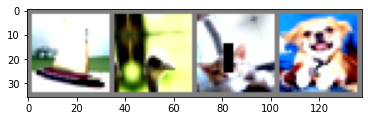

In [12]:
import matplotlib.pyplot as plt
import numpy as np

# functions to show an image


def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))


# get some random training images
dataiter = iter(trainloader)
images, labels = next(dataiter)

# show images
imshow(torchvision.utils.make_grid(images[:4]))
# print labels
print(' '.join('%5s' % classes[labels[j]] for j in range(4)))

# Define a Convolution Neural Network
Copy the neural network from the Neural Networks section before and modify it to
take 3-channel images (instead of 1-channel images as it was defined).



In [13]:
from google.colab import files
src = list(files.upload().values())[0]
open('model.py','wb').write(src)
import model as net

Saving model.py to model.py


# Model parameters

In [14]:
from torchscan import summary

device = torch.device("cuda" if cuda else "cpu")
print(device)
model = net.Net().to(device)
summary(model, (3, 32, 32), receptive_field=True, max_depth=1)

cuda
___________________________________________________________________________________________
Layer                         Type          Output Shape         Param #    Receptive field
net                           Net           (-1, 10)             0          1              
├─conv1                       Sequential    (-1, 16, 32, 32)     497        3              
├─conv2                       Sequential    (-1, 32, 30, 30)     4,737      5              
├─conv3                       Sequential    (-1, 64, 28, 28)     18,689     7              
├─conv4                       Sequential    (-1, 32, 28, 28)     18,561     9              
├─strided_pooling             Sequential    (-1, 64, 14, 14)     8,449      13             
├─conv5                       Sequential    (-1, 100, 12, 12)    58,001     17             
├─dialted_conv_1              Sequential    (-1, 64, 10, 10)     57,857     25             
├─dialted_conv_2              Sequential    (-1, 32, 8, 8)       18,561    

# Define a Loss function and optimizer

Let's use a Classification Cross-Entropy loss and SGD with momentum.



In [15]:
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)

# Train and test network

This is when things start to get interesting.
We simply have to loop over our data iterator, and feed the inputs to the
network and optimize.



In [16]:
from tqdm import tqdm

train_losses = []
test_losses = []
train_acc = []
test_acc = []

def train(model, device, train_loader, optimizer, epoch):
  model.train()
  pbar = tqdm(train_loader)
  correct = 0
  processed = 0
  for batch_idx, (data, target) in enumerate(pbar):
    # get samples
    data, target = data.to(device), target.to(device)

    # Init
    optimizer.zero_grad()
    # In PyTorch, we need to set the gradients to zero before starting to do backpropragation because PyTorch accumulates the gradients on subsequent backward passes. 
    # Because of this, when you start your training loop, ideally you should zero out the gradients so that you do the parameter update correctly.

    # Predict
    y_pred = model(data)

    # Calculate loss
    loss = F.nll_loss(y_pred, target)
    train_losses.append(loss.item())

    # Backpropagation
    loss.backward()
    optimizer.step()

    # Update pbar-tqdm
    
    pred = y_pred.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
    correct += pred.eq(target.view_as(pred)).sum().item()
    processed += len(data)

    pbar.set_description(desc= f'Loss={loss.item()} Batch_id={batch_idx} Accuracy={100*correct/processed:0.2f}')
    train_acc.append(100*correct/processed)

def test(model, device, test_loader):
    model.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            test_loss += F.nll_loss(output, target, reduction='sum').item()  # sum up batch loss
            pred = output.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
            correct += pred.eq(target.view_as(pred)).sum().item()

    test_loss /= len(test_loader.dataset)
    test_losses.append(test_loss)

    print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.2f}%)\n'.format(
        test_loss, correct, len(test_loader.dataset),
        100. * correct / len(test_loader.dataset)))
    
    test_acc.append(100. * correct / len(test_loader.dataset))

In [17]:
model =  net.Net().to(device)
optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9)
EPOCHS = 100
for epoch in range(EPOCHS):
    print("EPOCH:", epoch)
    train(model, device, trainloader, optimizer, epoch)
    test(model, device, testloader)

EPOCH: 0


  0%|          | 0/391 [00:00<?, ?it/s]/usr/local/lib/python3.8/dist-packages/torch/utils/data/dataloader.py:554: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
Loss=1.4100768566131592 Batch_id=390 Accuracy=39.10: 100%|██████████| 391/391 [00:14<00:00, 26.33it/s]



Test set: Average loss: 1.3491, Accuracy: 5214/10000 (52.14%)

EPOCH: 1


Loss=1.101167917251587 Batch_id=390 Accuracy=53.12: 100%|██████████| 391/391 [00:14<00:00, 26.70it/s]



Test set: Average loss: 1.0757, Accuracy: 6241/10000 (62.41%)

EPOCH: 2


Loss=0.9855639338493347 Batch_id=390 Accuracy=59.54: 100%|██████████| 391/391 [00:15<00:00, 24.44it/s]



Test set: Average loss: 0.9589, Accuracy: 6599/10000 (65.99%)

EPOCH: 3


Loss=0.7077467441558838 Batch_id=390 Accuracy=63.20: 100%|██████████| 391/391 [00:15<00:00, 25.88it/s]



Test set: Average loss: 0.8296, Accuracy: 7179/10000 (71.79%)

EPOCH: 4


Loss=1.037790060043335 Batch_id=390 Accuracy=65.79: 100%|██████████| 391/391 [00:14<00:00, 26.19it/s]



Test set: Average loss: 0.7751, Accuracy: 7300/10000 (73.00%)

EPOCH: 5


Loss=0.8778570890426636 Batch_id=390 Accuracy=67.95: 100%|██████████| 391/391 [00:14<00:00, 26.58it/s]



Test set: Average loss: 0.7529, Accuracy: 7439/10000 (74.39%)

EPOCH: 6


Loss=0.8845247030258179 Batch_id=390 Accuracy=69.44: 100%|██████████| 391/391 [00:15<00:00, 25.12it/s]



Test set: Average loss: 0.6995, Accuracy: 7612/10000 (76.12%)

EPOCH: 7


Loss=0.867866039276123 Batch_id=390 Accuracy=71.00: 100%|██████████| 391/391 [00:14<00:00, 26.21it/s]



Test set: Average loss: 0.6665, Accuracy: 7775/10000 (77.75%)

EPOCH: 8


Loss=0.8809100389480591 Batch_id=390 Accuracy=71.74: 100%|██████████| 391/391 [00:14<00:00, 26.53it/s]



Test set: Average loss: 0.6043, Accuracy: 7960/10000 (79.60%)

EPOCH: 9


Loss=0.8161999583244324 Batch_id=390 Accuracy=73.13: 100%|██████████| 391/391 [00:14<00:00, 26.32it/s]



Test set: Average loss: 0.5989, Accuracy: 7942/10000 (79.42%)

EPOCH: 10


Loss=1.0617307424545288 Batch_id=390 Accuracy=74.03: 100%|██████████| 391/391 [00:14<00:00, 26.42it/s]



Test set: Average loss: 0.5929, Accuracy: 7959/10000 (79.59%)

EPOCH: 11


Loss=0.6543681025505066 Batch_id=390 Accuracy=74.71: 100%|██████████| 391/391 [00:14<00:00, 26.69it/s]



Test set: Average loss: 0.5789, Accuracy: 8041/10000 (80.41%)

EPOCH: 12


Loss=0.6569517254829407 Batch_id=390 Accuracy=75.54: 100%|██████████| 391/391 [00:14<00:00, 26.63it/s]



Test set: Average loss: 0.5493, Accuracy: 8126/10000 (81.26%)

EPOCH: 13


Loss=0.6897684335708618 Batch_id=390 Accuracy=76.18: 100%|██████████| 391/391 [00:14<00:00, 26.50it/s]



Test set: Average loss: 0.5161, Accuracy: 8215/10000 (82.15%)

EPOCH: 14


Loss=0.7033057808876038 Batch_id=390 Accuracy=76.55: 100%|██████████| 391/391 [00:14<00:00, 26.62it/s]



Test set: Average loss: 0.5024, Accuracy: 8275/10000 (82.75%)

EPOCH: 15


Loss=0.8130103945732117 Batch_id=390 Accuracy=77.37: 100%|██████████| 391/391 [00:14<00:00, 26.27it/s]



Test set: Average loss: 0.5416, Accuracy: 8177/10000 (81.77%)

EPOCH: 16


Loss=0.4928886294364929 Batch_id=390 Accuracy=77.86: 100%|██████████| 391/391 [00:14<00:00, 26.65it/s]



Test set: Average loss: 0.4932, Accuracy: 8352/10000 (83.52%)

EPOCH: 17


Loss=0.6998488306999207 Batch_id=390 Accuracy=78.03: 100%|██████████| 391/391 [00:14<00:00, 26.58it/s]



Test set: Average loss: 0.4740, Accuracy: 8391/10000 (83.91%)

EPOCH: 18


Loss=0.6195247769355774 Batch_id=390 Accuracy=78.45: 100%|██████████| 391/391 [00:14<00:00, 26.83it/s]



Test set: Average loss: 0.4667, Accuracy: 8405/10000 (84.05%)

EPOCH: 19


Loss=0.6849194765090942 Batch_id=390 Accuracy=78.99: 100%|██████████| 391/391 [00:14<00:00, 26.81it/s]



Test set: Average loss: 0.4545, Accuracy: 8470/10000 (84.70%)

EPOCH: 20


Loss=0.5699149370193481 Batch_id=390 Accuracy=79.47: 100%|██████████| 391/391 [00:14<00:00, 26.83it/s]



Test set: Average loss: 0.4698, Accuracy: 8403/10000 (84.03%)

EPOCH: 21


Loss=0.5494986772537231 Batch_id=390 Accuracy=79.28: 100%|██████████| 391/391 [00:14<00:00, 26.86it/s]



Test set: Average loss: 0.4529, Accuracy: 8496/10000 (84.96%)

EPOCH: 22


Loss=0.4741853177547455 Batch_id=390 Accuracy=79.96: 100%|██████████| 391/391 [00:14<00:00, 26.30it/s]



Test set: Average loss: 0.4481, Accuracy: 8505/10000 (85.05%)

EPOCH: 23


Loss=0.6501418948173523 Batch_id=390 Accuracy=80.42: 100%|██████████| 391/391 [00:14<00:00, 26.33it/s]



Test set: Average loss: 0.4567, Accuracy: 8492/10000 (84.92%)

EPOCH: 24


Loss=0.6385985612869263 Batch_id=390 Accuracy=80.51: 100%|██████████| 391/391 [00:14<00:00, 26.34it/s]



Test set: Average loss: 0.4392, Accuracy: 8542/10000 (85.42%)

EPOCH: 25


Loss=0.7336381077766418 Batch_id=390 Accuracy=80.76: 100%|██████████| 391/391 [00:14<00:00, 26.73it/s]



Test set: Average loss: 0.4421, Accuracy: 8510/10000 (85.10%)

EPOCH: 26


Loss=0.5361734628677368 Batch_id=390 Accuracy=81.00: 100%|██████████| 391/391 [00:14<00:00, 26.32it/s]



Test set: Average loss: 0.4349, Accuracy: 8558/10000 (85.58%)

EPOCH: 27


Loss=0.69942307472229 Batch_id=390 Accuracy=81.33: 100%|██████████| 391/391 [00:14<00:00, 26.83it/s]



Test set: Average loss: 0.4293, Accuracy: 8552/10000 (85.52%)

EPOCH: 28


Loss=0.293628454208374 Batch_id=390 Accuracy=81.74: 100%|██████████| 391/391 [00:14<00:00, 26.96it/s]



Test set: Average loss: 0.4177, Accuracy: 8596/10000 (85.96%)

EPOCH: 29


Loss=0.5457843542098999 Batch_id=390 Accuracy=81.82: 100%|██████████| 391/391 [00:14<00:00, 26.30it/s]



Test set: Average loss: 0.4202, Accuracy: 8592/10000 (85.92%)

EPOCH: 30


Loss=0.48258310556411743 Batch_id=390 Accuracy=82.07: 100%|██████████| 391/391 [00:14<00:00, 26.85it/s]



Test set: Average loss: 0.4136, Accuracy: 8616/10000 (86.16%)

EPOCH: 31


Loss=0.5877835154533386 Batch_id=390 Accuracy=82.21: 100%|██████████| 391/391 [00:14<00:00, 26.90it/s]



Test set: Average loss: 0.4126, Accuracy: 8610/10000 (86.10%)

EPOCH: 32


Loss=0.5683314800262451 Batch_id=390 Accuracy=82.46: 100%|██████████| 391/391 [00:14<00:00, 26.94it/s]



Test set: Average loss: 0.4199, Accuracy: 8615/10000 (86.15%)

EPOCH: 33


Loss=0.49522289633750916 Batch_id=390 Accuracy=82.68: 100%|██████████| 391/391 [00:14<00:00, 26.89it/s]



Test set: Average loss: 0.3996, Accuracy: 8620/10000 (86.20%)

EPOCH: 34


Loss=0.326888769865036 Batch_id=390 Accuracy=82.62: 100%|██████████| 391/391 [00:14<00:00, 27.18it/s]



Test set: Average loss: 0.4119, Accuracy: 8622/10000 (86.22%)

EPOCH: 35


Loss=0.5274581909179688 Batch_id=390 Accuracy=82.81: 100%|██████████| 391/391 [00:14<00:00, 27.34it/s]



Test set: Average loss: 0.4217, Accuracy: 8588/10000 (85.88%)

EPOCH: 36


Loss=0.4315095543861389 Batch_id=390 Accuracy=82.99: 100%|██████████| 391/391 [00:14<00:00, 27.14it/s]



Test set: Average loss: 0.3875, Accuracy: 8666/10000 (86.66%)

EPOCH: 37


Loss=0.2693461775779724 Batch_id=390 Accuracy=83.08: 100%|██████████| 391/391 [00:14<00:00, 27.00it/s]



Test set: Average loss: 0.4008, Accuracy: 8666/10000 (86.66%)

EPOCH: 38


Loss=0.3489835858345032 Batch_id=390 Accuracy=83.48: 100%|██████████| 391/391 [00:14<00:00, 26.64it/s]



Test set: Average loss: 0.4018, Accuracy: 8637/10000 (86.37%)

EPOCH: 39


Loss=0.36738818883895874 Batch_id=390 Accuracy=83.53: 100%|██████████| 391/391 [00:14<00:00, 27.11it/s]



Test set: Average loss: 0.3796, Accuracy: 8707/10000 (87.07%)

EPOCH: 40


Loss=0.4846802353858948 Batch_id=390 Accuracy=83.88: 100%|██████████| 391/391 [00:14<00:00, 26.75it/s]



Test set: Average loss: 0.4045, Accuracy: 8624/10000 (86.24%)

EPOCH: 41


Loss=0.35158246755599976 Batch_id=390 Accuracy=83.91: 100%|██████████| 391/391 [00:14<00:00, 27.52it/s]



Test set: Average loss: 0.3912, Accuracy: 8674/10000 (86.74%)

EPOCH: 42


Loss=0.5374161005020142 Batch_id=390 Accuracy=83.61: 100%|██████████| 391/391 [00:14<00:00, 27.07it/s]



Test set: Average loss: 0.3835, Accuracy: 8719/10000 (87.19%)

EPOCH: 43


Loss=0.3775615990161896 Batch_id=390 Accuracy=84.01: 100%|██████████| 391/391 [00:14<00:00, 26.71it/s]



Test set: Average loss: 0.3960, Accuracy: 8674/10000 (86.74%)

EPOCH: 44


Loss=0.5457832217216492 Batch_id=390 Accuracy=84.21: 100%|██████████| 391/391 [00:14<00:00, 26.97it/s]



Test set: Average loss: 0.3900, Accuracy: 8719/10000 (87.19%)

EPOCH: 45


Loss=0.3604312837123871 Batch_id=390 Accuracy=84.02: 100%|██████████| 391/391 [00:14<00:00, 26.93it/s]



Test set: Average loss: 0.3902, Accuracy: 8730/10000 (87.30%)

EPOCH: 46


Loss=0.4653453826904297 Batch_id=390 Accuracy=84.30: 100%|██████████| 391/391 [00:14<00:00, 26.79it/s]



Test set: Average loss: 0.3854, Accuracy: 8728/10000 (87.28%)

EPOCH: 47


Loss=0.3294883370399475 Batch_id=390 Accuracy=84.50: 100%|██████████| 391/391 [00:14<00:00, 27.10it/s]



Test set: Average loss: 0.3935, Accuracy: 8699/10000 (86.99%)

EPOCH: 48


Loss=0.4057998061180115 Batch_id=390 Accuracy=84.71: 100%|██████████| 391/391 [00:14<00:00, 27.05it/s]



Test set: Average loss: 0.3761, Accuracy: 8714/10000 (87.14%)

EPOCH: 49


Loss=0.501541793346405 Batch_id=390 Accuracy=84.59: 100%|██████████| 391/391 [00:14<00:00, 26.65it/s]



Test set: Average loss: 0.3774, Accuracy: 8730/10000 (87.30%)

EPOCH: 50


Loss=0.4909138083457947 Batch_id=390 Accuracy=84.69: 100%|██████████| 391/391 [00:14<00:00, 27.28it/s]



Test set: Average loss: 0.3893, Accuracy: 8696/10000 (86.96%)

EPOCH: 51


Loss=0.5052950978279114 Batch_id=390 Accuracy=84.94: 100%|██████████| 391/391 [00:14<00:00, 27.12it/s]



Test set: Average loss: 0.3670, Accuracy: 8769/10000 (87.69%)

EPOCH: 52


Loss=0.4107266366481781 Batch_id=390 Accuracy=84.95: 100%|██████████| 391/391 [00:14<00:00, 27.39it/s]



Test set: Average loss: 0.3873, Accuracy: 8715/10000 (87.15%)

EPOCH: 53


Loss=0.3159378170967102 Batch_id=390 Accuracy=84.94: 100%|██████████| 391/391 [00:14<00:00, 26.99it/s]



Test set: Average loss: 0.3635, Accuracy: 8770/10000 (87.70%)

EPOCH: 54


Loss=0.33736705780029297 Batch_id=390 Accuracy=85.25: 100%|██████████| 391/391 [00:14<00:00, 27.20it/s]



Test set: Average loss: 0.3739, Accuracy: 8745/10000 (87.45%)

EPOCH: 55


Loss=0.4624277949333191 Batch_id=390 Accuracy=85.19: 100%|██████████| 391/391 [00:14<00:00, 27.22it/s]



Test set: Average loss: 0.3810, Accuracy: 8738/10000 (87.38%)

EPOCH: 56


Loss=0.5083204507827759 Batch_id=390 Accuracy=85.29: 100%|██████████| 391/391 [00:14<00:00, 27.06it/s]



Test set: Average loss: 0.3831, Accuracy: 8743/10000 (87.43%)

EPOCH: 57


Loss=0.40249380469322205 Batch_id=390 Accuracy=85.44: 100%|██████████| 391/391 [00:14<00:00, 26.98it/s]



Test set: Average loss: 0.3846, Accuracy: 8748/10000 (87.48%)

EPOCH: 58


Loss=0.38430696725845337 Batch_id=390 Accuracy=85.79: 100%|██████████| 391/391 [00:14<00:00, 26.80it/s]



Test set: Average loss: 0.3738, Accuracy: 8782/10000 (87.82%)

EPOCH: 59


Loss=0.3805256485939026 Batch_id=390 Accuracy=85.75: 100%|██████████| 391/391 [00:14<00:00, 26.97it/s]



Test set: Average loss: 0.3911, Accuracy: 8689/10000 (86.89%)

EPOCH: 60


Loss=0.3953688442707062 Batch_id=390 Accuracy=85.50: 100%|██████████| 391/391 [00:14<00:00, 27.16it/s]



Test set: Average loss: 0.3704, Accuracy: 8761/10000 (87.61%)

EPOCH: 61


Loss=0.3772139251232147 Batch_id=390 Accuracy=85.74: 100%|██████████| 391/391 [00:14<00:00, 27.27it/s]



Test set: Average loss: 0.3663, Accuracy: 8758/10000 (87.58%)

EPOCH: 62


Loss=0.6880718469619751 Batch_id=390 Accuracy=85.69: 100%|██████████| 391/391 [00:14<00:00, 26.82it/s]



Test set: Average loss: 0.3748, Accuracy: 8749/10000 (87.49%)

EPOCH: 63


Loss=0.3337380588054657 Batch_id=390 Accuracy=86.01: 100%|██████████| 391/391 [00:14<00:00, 27.14it/s]



Test set: Average loss: 0.3624, Accuracy: 8786/10000 (87.86%)

EPOCH: 64


Loss=0.34242454171180725 Batch_id=390 Accuracy=86.14: 100%|██████████| 391/391 [00:14<00:00, 27.17it/s]



Test set: Average loss: 0.3658, Accuracy: 8781/10000 (87.81%)

EPOCH: 65


Loss=0.4731265902519226 Batch_id=390 Accuracy=86.10: 100%|██████████| 391/391 [00:14<00:00, 26.94it/s]



Test set: Average loss: 0.3739, Accuracy: 8780/10000 (87.80%)

EPOCH: 66


Loss=0.6356111168861389 Batch_id=390 Accuracy=86.14: 100%|██████████| 391/391 [00:14<00:00, 26.68it/s]



Test set: Average loss: 0.3697, Accuracy: 8821/10000 (88.21%)

EPOCH: 67


Loss=0.5232993364334106 Batch_id=390 Accuracy=86.33: 100%|██████████| 391/391 [00:14<00:00, 26.56it/s]



Test set: Average loss: 0.3715, Accuracy: 8733/10000 (87.33%)

EPOCH: 68


Loss=0.3756456971168518 Batch_id=390 Accuracy=86.20: 100%|██████████| 391/391 [00:14<00:00, 26.77it/s]



Test set: Average loss: 0.3713, Accuracy: 8782/10000 (87.82%)

EPOCH: 69


Loss=0.5621765851974487 Batch_id=390 Accuracy=86.36: 100%|██████████| 391/391 [00:14<00:00, 26.89it/s]



Test set: Average loss: 0.3595, Accuracy: 8806/10000 (88.06%)

EPOCH: 70


Loss=0.4815307557582855 Batch_id=390 Accuracy=86.36: 100%|██████████| 391/391 [00:14<00:00, 26.86it/s]



Test set: Average loss: 0.3636, Accuracy: 8815/10000 (88.15%)

EPOCH: 71


Loss=0.28378742933273315 Batch_id=390 Accuracy=86.59: 100%|██████████| 391/391 [00:14<00:00, 26.78it/s]



Test set: Average loss: 0.3610, Accuracy: 8816/10000 (88.16%)

EPOCH: 72


Loss=0.3236615061759949 Batch_id=390 Accuracy=86.70: 100%|██████████| 391/391 [00:14<00:00, 26.87it/s]



Test set: Average loss: 0.3770, Accuracy: 8766/10000 (87.66%)

EPOCH: 73


Loss=0.38582995533943176 Batch_id=390 Accuracy=86.84: 100%|██████████| 391/391 [00:14<00:00, 26.70it/s]



Test set: Average loss: 0.3617, Accuracy: 8813/10000 (88.13%)

EPOCH: 74


Loss=0.3250630497932434 Batch_id=390 Accuracy=86.66: 100%|██████████| 391/391 [00:14<00:00, 26.91it/s]



Test set: Average loss: 0.3603, Accuracy: 8827/10000 (88.27%)

EPOCH: 75


Loss=0.3007829487323761 Batch_id=390 Accuracy=86.88: 100%|██████████| 391/391 [00:14<00:00, 26.74it/s]



Test set: Average loss: 0.3657, Accuracy: 8786/10000 (87.86%)

EPOCH: 76


Loss=0.5058494210243225 Batch_id=390 Accuracy=86.80: 100%|██████████| 391/391 [00:14<00:00, 26.80it/s]



Test set: Average loss: 0.3731, Accuracy: 8792/10000 (87.92%)

EPOCH: 77


Loss=0.42495352029800415 Batch_id=390 Accuracy=86.71: 100%|██████████| 391/391 [00:14<00:00, 26.97it/s]



Test set: Average loss: 0.3526, Accuracy: 8857/10000 (88.57%)

EPOCH: 78


Loss=0.3103190064430237 Batch_id=390 Accuracy=86.95: 100%|██████████| 391/391 [00:14<00:00, 26.93it/s]



Test set: Average loss: 0.3682, Accuracy: 8831/10000 (88.31%)

EPOCH: 79


Loss=0.36960476636886597 Batch_id=390 Accuracy=87.04: 100%|██████████| 391/391 [00:14<00:00, 26.97it/s]



Test set: Average loss: 0.3592, Accuracy: 8818/10000 (88.18%)

EPOCH: 80


Loss=0.3240169882774353 Batch_id=390 Accuracy=86.90: 100%|██████████| 391/391 [00:14<00:00, 26.58it/s]



Test set: Average loss: 0.3568, Accuracy: 8839/10000 (88.39%)

EPOCH: 81


Loss=0.39214596152305603 Batch_id=390 Accuracy=86.95: 100%|██████████| 391/391 [00:14<00:00, 26.69it/s]



Test set: Average loss: 0.3491, Accuracy: 8852/10000 (88.52%)

EPOCH: 82


Loss=0.3178854286670685 Batch_id=390 Accuracy=87.04: 100%|██████████| 391/391 [00:14<00:00, 26.61it/s]



Test set: Average loss: 0.3607, Accuracy: 8830/10000 (88.30%)

EPOCH: 83


Loss=0.4628846049308777 Batch_id=390 Accuracy=86.95: 100%|██████████| 391/391 [00:14<00:00, 26.78it/s]



Test set: Average loss: 0.3465, Accuracy: 8872/10000 (88.72%)

EPOCH: 84


Loss=0.5237066149711609 Batch_id=390 Accuracy=87.00: 100%|██████████| 391/391 [00:14<00:00, 26.68it/s]



Test set: Average loss: 0.3516, Accuracy: 8887/10000 (88.87%)

EPOCH: 85


Loss=0.45457887649536133 Batch_id=390 Accuracy=87.30: 100%|██████████| 391/391 [00:14<00:00, 26.51it/s]



Test set: Average loss: 0.3640, Accuracy: 8822/10000 (88.22%)

EPOCH: 86


Loss=0.3724238872528076 Batch_id=390 Accuracy=87.07: 100%|██████████| 391/391 [00:14<00:00, 26.45it/s]



Test set: Average loss: 0.3473, Accuracy: 8843/10000 (88.43%)

EPOCH: 87


Loss=0.3300686478614807 Batch_id=390 Accuracy=87.32: 100%|██████████| 391/391 [00:14<00:00, 27.18it/s]



Test set: Average loss: 0.3584, Accuracy: 8838/10000 (88.38%)

EPOCH: 88


Loss=0.4502674639225006 Batch_id=390 Accuracy=87.47: 100%|██████████| 391/391 [00:14<00:00, 26.67it/s]



Test set: Average loss: 0.3583, Accuracy: 8830/10000 (88.30%)

EPOCH: 89


Loss=0.2821332514286041 Batch_id=390 Accuracy=87.74: 100%|██████████| 391/391 [00:14<00:00, 26.71it/s]



Test set: Average loss: 0.3424, Accuracy: 8895/10000 (88.95%)

EPOCH: 90


Loss=0.43347805738449097 Batch_id=390 Accuracy=87.53: 100%|██████████| 391/391 [00:14<00:00, 26.53it/s]



Test set: Average loss: 0.3413, Accuracy: 8862/10000 (88.62%)

EPOCH: 91


Loss=0.3070293068885803 Batch_id=390 Accuracy=87.55: 100%|██████████| 391/391 [00:14<00:00, 26.74it/s]



Test set: Average loss: 0.3474, Accuracy: 8880/10000 (88.80%)

EPOCH: 92


Loss=0.31107980012893677 Batch_id=390 Accuracy=87.45: 100%|██████████| 391/391 [00:14<00:00, 26.52it/s]



Test set: Average loss: 0.3575, Accuracy: 8848/10000 (88.48%)

EPOCH: 93


Loss=0.49440670013427734 Batch_id=390 Accuracy=87.62: 100%|██████████| 391/391 [00:14<00:00, 26.76it/s]



Test set: Average loss: 0.3496, Accuracy: 8847/10000 (88.47%)

EPOCH: 94


Loss=0.36978879570961 Batch_id=390 Accuracy=87.61: 100%|██████████| 391/391 [00:14<00:00, 27.00it/s]



Test set: Average loss: 0.3542, Accuracy: 8858/10000 (88.58%)

EPOCH: 95


Loss=0.46164244413375854 Batch_id=390 Accuracy=87.49: 100%|██████████| 391/391 [00:14<00:00, 26.34it/s]



Test set: Average loss: 0.3423, Accuracy: 8861/10000 (88.61%)

EPOCH: 96


Loss=0.27673572301864624 Batch_id=390 Accuracy=87.84: 100%|██████████| 391/391 [00:14<00:00, 26.49it/s]



Test set: Average loss: 0.3503, Accuracy: 8877/10000 (88.77%)

EPOCH: 97


Loss=0.3403802216053009 Batch_id=390 Accuracy=87.91: 100%|██████████| 391/391 [00:14<00:00, 26.30it/s]



Test set: Average loss: 0.3450, Accuracy: 8899/10000 (88.99%)

EPOCH: 98


Loss=0.5887308120727539 Batch_id=390 Accuracy=87.71: 100%|██████████| 391/391 [00:15<00:00, 25.49it/s]



Test set: Average loss: 0.3449, Accuracy: 8882/10000 (88.82%)

EPOCH: 99


Loss=0.47484105825424194 Batch_id=390 Accuracy=87.72: 100%|██████████| 391/391 [00:15<00:00, 25.82it/s]



Test set: Average loss: 0.3549, Accuracy: 8845/10000 (88.45%)



# Plotting train and test accuracys

Text(0.5, 1.0, 'Test Accuracy')

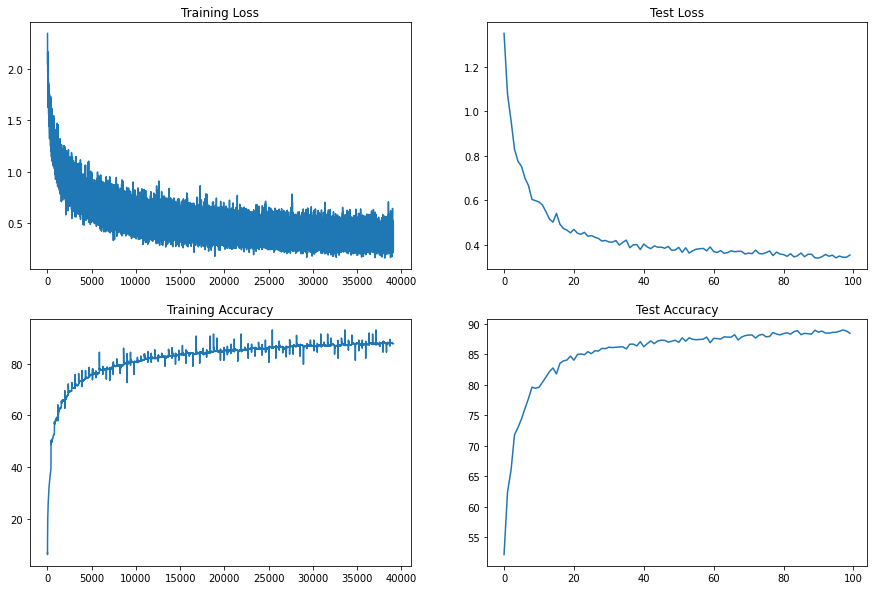

In [18]:
fig, axs = plt.subplots(2,2,figsize=(15,10))
axs[0, 0].plot(train_losses)
axs[0, 0].set_title("Training Loss")
axs[1, 0].plot(train_acc)
axs[1, 0].set_title("Training Accuracy")
axs[0, 1].plot(test_losses)
axs[0, 1].set_title("Test Loss")
axs[1, 1].plot(test_acc)
axs[1, 1].set_title("Test Accuracy")

# Test the network on the test data

We have trained the network for 2 passes over the training dataset.
But we need to check if the network has learnt anything at all.

We will check this by predicting the class label that the neural network
outputs, and checking it against the ground-truth. If the prediction is
correct, we add the sample to the list of correct predictions.

Okay, first step. Let us display an image from the test set to get familiar.



GroundTruth:  plane   dog  bird truck


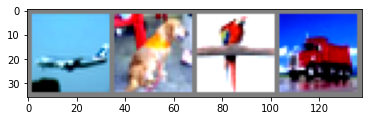

In [19]:
dataiter = iter(testloader)
images, labels = next(dataiter)
images, labels = images.to(device), labels.to(device)

# print images
imshow(torchvision.utils.make_grid(images[:4].cpu()))
print('GroundTruth: ', ' '.join('%5s' % classes[labels[j]] for j in range(4)))

### Okay, now let us see what the neural network thinks these examples above are:



In [20]:
outputs = model(images)

The outputs are energies for the 10 classes.
Higher the energy for a class, the more the network
thinks that the image is of the particular class.
So, let's get the index of the highest energy:



In [21]:
_, predicted = torch.max(outputs, 1)

print('Predicted: ', ' '.join('%5s' % classes[predicted[j]]
                              for j in range(4)))

Predicted:  plane   cat plane truck


### The results seem pretty good.

Let us look at how the network performs on the whole dataset.



In [22]:
correct = 0
total = 0
with torch.no_grad():
    for data in testloader:
        images, labels = data
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print('Accuracy of the network on the 10000 test images: %d %%' % (
    100 * correct / total))

Accuracy of the network on the 10000 test images: 88 %


### Randomly picking a class out of 10 classes.
Seems like the network learnt something.

Hmmm, what are the classes that performed well, and the classes that did
not perform well:



In [23]:
class_correct = list(0. for i in range(10))
class_total = list(0. for i in range(10))
with torch.no_grad():
    for data in testloader:
        images, labels = data
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs, 1)
        c = (predicted == labels).squeeze()
        for i in range(4):
            label = labels[i]
            class_correct[label] += c[i].item()
            class_total[label] += 1


for i in range(10):
    print('Accuracy of %5s : %2d %%' % (
        classes[i], 100 * class_correct[i] / class_total[i]))

Accuracy of plane : 82 %
Accuracy of   car : 95 %
Accuracy of  bird : 75 %
Accuracy of   cat : 77 %
Accuracy of  deer : 86 %
Accuracy of   dog : 81 %
Accuracy of  frog : 97 %
Accuracy of horse : 93 %
Accuracy of  ship : 96 %
Accuracy of truck : 93 %
